<a href="https://colab.research.google.com/github/francescobellina/Repo_laboratorio_BiophotonicsI/blob/main/Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ 1200000.         7890000.        10500000.         9500000.
 58200000.         3599999.9999956  3000000.         1800000.       ]


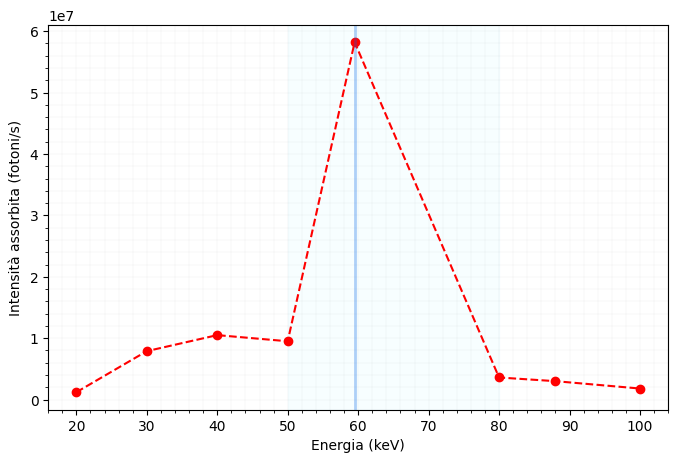

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def attenua(intensita0, mu_rho, rho, x=1):
    """
    Calcola l'intensità assorbita in uno spessore x di piombo.

    Parametri:
        intensita0 : array numpy
        mu_rho     : array numpy del coefficiente massico (cm^2/g)
        rho        : densità (g/cm^3)
        x          : spessore (cm) del piombo

    Output:
        array numpy dell'intensità assorbita
    """
    mu = mu_rho * rho
    return intensita0 * (1 - np.exp(-mu * x))


# Dati
intensit0 = np.array([1.2, 7.89, 10.5, 9.5, 58.2, 3.6, 3.0, 1.8]) * 1e6
mu_rho = np.array([86.36, 30.32, 8.04, 14.36, 5.021, 2.419, 7.68, 5.549])
rho = 11.34  # densità del piombo
energy = np.array([20, 30, 40, 50, 59.5, 80, 88, 100])

# Calcolo intensità attenuata
intensit_atten = attenua(intensit0, mu_rho, rho)

print(intensit_atten)

# Grafico
plt.figure(figsize=(8, 5))
plt.plot(energy, intensit_atten, marker='o', linestyle='--', color='red')

# Area colorata in ciano chiaro tra 50 e 80 keV
plt.axvspan(50, 80, color='#d6faff', alpha=0.18)

# Retta verticale blu oltremare (quasi trasparente) a 59.5 keV, esempio
plt.axvline(59.5, color='#0366e6', alpha=0.3, linewidth=2)

plt.xlabel("Energia (keV)")
plt.ylabel("Intensità assorbita (fotoni/s)")
#plt.title("Intensità assorbita da  cm di piombo")
plt.grid(visible=True, which='both', axis='both', color='gray', alpha=0.2, linestyle='-', linewidth=0.2)
plt.minorticks_on()
plt.show()

#PATRICLE TRACKING AND DIFFUSION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("ciao")

ciao


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

file_path = '/content/drive/MyDrive/Experiment_spots_002.csv'

df = pd.read_csv(file_path, skiprows=3)
print("Nomi colonne effettive:", list(df.columns))

# Estrai le colonne delle coordinate (micron) in base all'ordine delle colonne
x_data = df['(micron)'].astype(float).values
y_data = df['(micron).1'].astype(float).values

# ---- Stampa ordinata delle prime 20 coordinate x/y ----
first20_df = pd.DataFrame({'X (micron)': x_data[:20], 'Y (micron)': y_data[:20]})
print("\nPrime 20 coordinate (x,y):")
print(first20_df)

# Se hai più tracce, ricostruisci traiettorie (qui presupponiamo Track ID in 'Unnamed: 1')
tracks = df['Unnamed: 1'].astype(str).values
frames = df['Unnamed: 9'] if 'Unnamed: 9' in df.columns else np.arange(len(x_data))

unique_tracks = np.unique(tracks)
num_frames = len(np.unique(frames))
x_trajs = np.zeros((len(unique_tracks), num_frames))
y_trajs = np.zeros((len(unique_tracks), num_frames))
for i, track in enumerate(unique_tracks):
    mask = tracks == track
    sort_idx = np.argsort(frames[mask])
    x_trajs[i, :] = x_data[mask][sort_idx]
    y_trajs[i, :] = y_data[mask][sort_idx]

# --- MSD analysis ---
def eaMSD(x_trajs, y_trajs, n):
    return np.nanmean((x_trajs[:, n] - x_trajs[:, 0])**2 + (y_trajs[:, n] - y_trajs[:, 0])**2)
def taMSD(x, y, n):
    disp = (x[n:] - x[:-n])**2 + (y[n:] - y[:-n])**2
    return np.nanmean(disp)
def msd_vs_time(x_trajs, y_trajs, max_lag):
    ea = [eaMSD(x_trajs, y_trajs, n) for n in range(1, max_lag)]
    ta = np.mean([[taMSD(x, y, n) for n in range(1, max_lag)] for x, y in zip(x_trajs, y_trajs)], axis=0)
    return ea, ta

M, N = x_trajs.shape
max_lag = min(N//2, N-1)
dt = 0.1
time = np.arange(N) * dt

ea, ta = msd_vs_time(x_trajs, y_trajs, max_lag)
lags = np.arange(1, max_lag) * dt

plt.figure()
plt.plot(lags, ea, label='Ensemble MSD')
plt.plot(lags, ta, label='Time-averaged MSD')
if len(ea) > 1:
    D_estimate = ea[1] / (4 * dt)
    plt.plot(lags, 4 * D_estimate * lags, '--', label=f'4Dt (theory, D~{D_estimate:.2f})')
plt.xlabel(r't (s)')
plt.ylabel(r'MSD ($\mu m^2$)')
plt.legend()
plt.title('Mean Square Displacement')
plt.show()

plt.figure()
for t_idx, t_col in zip([10, 20, 40, 80], ['b', 'r', 'g', 'c']):
    if t_idx < N:
        x_now = x_trajs[:, t_idx]
        mu, std = np.nanmean(x_now), np.nanstd(x_now)
        x_vals = np.linspace(mu - 4*std, mu + 4*std, 100)
        plt.plot(x_vals, norm.pdf(x_vals, mu, std), label=f't={time[t_idx]:.1f}s')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel('p(x,t)')
plt.title('Distribution of x at different times')
plt.legend()
plt.show()


Nomi colonne effettive: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', '(quality)', '(micron)', '(micron).1', '(micron).2', '(sec)', 'Unnamed: 8', '(micron).3', 'Unnamed: 10', 'Unnamed: 11', '(counts)', '(counts).1', '(counts).2', '(counts).3', '(counts).4', '(counts).5', 'Unnamed: 18', 'Unnamed: 19']

Prime 20 coordinate (x,y):
    X (micron)  Y (micron)
0    10.469439   18.039649
1    10.308371   17.798047
2    10.066769   18.120183
3    10.630508   17.717513
4    10.469439   18.039649
5    10.952644   17.234308
6    10.711042   17.959115
7    10.791576   17.475910
8    11.194247   17.234308
9    11.435849   17.073240
10   11.435849   16.912171
11   11.516383   16.912171
12   12.080122   16.106830
13   12.160656   15.945761
14   12.241191   15.784693
15   12.482793   14.818283
16   12.402259   15.220954
17   12.965998   14.657215
18   13.288135   14.415613
19   13.288135   14.496147
